<a href="https://colab.research.google.com/github/ChihabFortas/Fraud-detection-Model/blob/dev_1/ML_academy_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fraud Detection using regression model**

### **Project overview**
The Tunisian company of electricity and gaz (STEG) is a non-administrative company, it is responsible for delivering electricity and gaz across Tunisia.
The company sufferred tremendous losses in order of 200 million tunisian dinars due to fraudelant manipulations of meters by consumers.

in this project we will be using data gathered by the company (Clients billing/consumption history) to detect and recognize clients involved in fraudelent activities. 

###**Project structure** 
before start writing any code, first we need to understand the problem in details and set a some milestones to achieve in this project.
- Preparing the workspace
  - importing libraries
  - downloading and imporing the data and converting it into a readable dataset
- Exploratory Data Analysis
  - Understanding the data 
  - Data preparation and cleaning
  - feature engineering and picking neccesary features to build the model
- Model creation
  - Decide which type of Model fit to solve the problem in hand
  - Create the model based on input and output shape and the depth of model network
  - Create the model hyperparamater
  - create the training job 

- Visualizing and tuning
  - continue visualizing and tuning the hyperparamaters until we reach a optimized state
  - Model validation and testing

- Submission
  - extract the prediction to a csv file

###**Preparing the workspace**

In [ ]:
# For Python 2 / 3 compatability
from __future__ import print_function

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from datetime import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

seed=47

print("Imported modules.")

Imported modules.


###**Load the dataset**
we will be using the dataset provided to us by the ML academy via google drive. The following code cell download the data from google drive, loads it and then creates the following two pandas DataFrames:

*   invoice_train: which contains invoices data for the training
*   client_train : which contains clients data for the training
*   invoice_test : which contains invoices data for the testing
*   cleint_test  : which contains clients data for the testing

In [ ]:
#Downloading the train.zip file from the provided link https://drive.google.com/file/d/1DxxZ166bZ8MocyM210DODckm926xm4HJ/view?usp=sharing
!gdown --id '1DxxZ166bZ8MocyM210DODckm926xm4HJ'
#Downloading the test.zip file from the provided link https://drive.google.com/file/d/1Unhg1OagxzEmaiCvgqLbRumIoDjx4AcV/view?usp=sharing
!gdown --id '1Unhg1OagxzEmaiCvgqLbRumIoDjx4AcV'
#Downloading the submission csv file from the provided link https://drive.google.com/file/d/1tDq9b20lOEMB30VcHclBMaqF_4Ey96Q5/view?usp=sharing
!gdown --id '1tDq9b20lOEMB30VcHclBMaqF_4Ey96Q5'

from zipfile import ZipFile
files = ['train.zip', 'test.zip']
export_path = "dataset/"
for f in files:
  zf = ZipFile(f, 'r')
  zf.extractall(export_path)
  zf.close()

Downloading...
From: https://drive.google.com/uc?id=1DxxZ166bZ8MocyM210DODckm926xm4HJ
To: /content/train.zip
100% 64.2M/64.2M [00:00<00:00, 196MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Unhg1OagxzEmaiCvgqLbRumIoDjx4AcV
To: /content/test.zip
100% 27.7M/27.7M [00:00<00:00, 246MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tDq9b20lOEMB30VcHclBMaqF_4Ey96Q5
To: /content/SampleSubmission.csv
100% 2.15M/2.15M [00:00<00:00, 145MB/s]


In [ ]:
client_test = pd.read_csv('dataset/client_test.csv')
invoice_test = pd.read_csv('dataset/invoice_test.csv')
client_train = pd.read_csv('dataset/client_train.csv')
invoice_train = pd.read_csv('dataset/invoice_train.csv')
sample_submission = pd.read_csv('SampleSubmission.csv',low_memory=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###**Exploratory Data Analysis**

First we check the dataframes for length and columns and types 

In [ ]:
print(client_train.info())
print('\n',client_train.describe())
print('\nnumber of entries {}'.format(client_train.shape))
client_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB
None

        disrict  client_catg   region   target
count 135493.0     135493.0 135493.0 135493.0
mean      63.5         11.5    206.2      0.1
std        3.4          4.4    104.2      0.2
min       60.0         11.0    101.0      0.0
25%       62.0         11.0    103.0      0.0
50%       62.0         11.0    107.0      0.0
75%       69.0         11.0    307.0      0.0
max       69.0         51.0    399.0      1.0

number of entries (135493, 6)


,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
print(invoice_train.info())
print('\n',invoice_train.describe())
print('\nnumber of entries {}'.format(invoice_train.shape))
invoice_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB
None

        tarif_type   counter_number  ...  new_index  months_number
count   4476749.0        4476749.0  ...  4476749.0      4476749.0
mean         20.1   123058699065.2  ...    18349.7           44.8
std          13.5

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


The exploration of data types reveals that most columns have appropriate types, except for the **'client_id'** that should be set to a string and the **'invoide_data'** and **'creation_date'** that should be transformed into a datetime, the **'counter_statue'** seems to have an string outlier in a numeric column. other than that the description also show that there is no missing data in the dataset for all columns. The district and the client_catg seem to have very close values with a quantile having very close values.

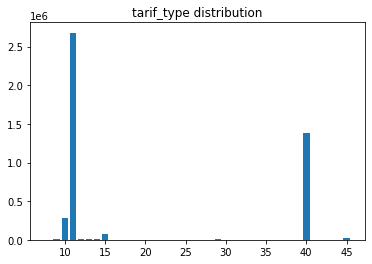

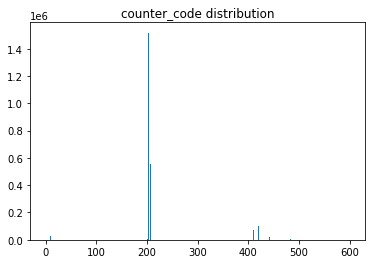

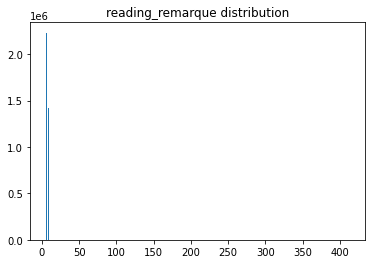

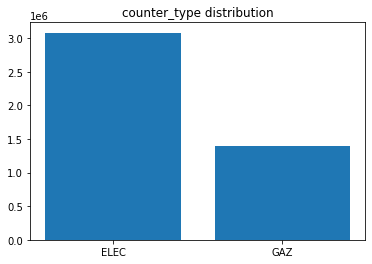

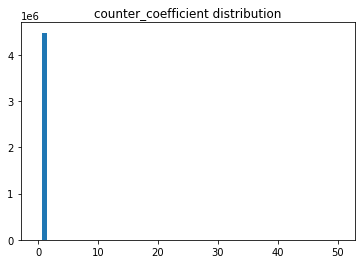

In [ ]:
# Ploting data from the Invoice training data
invoice_columns = ['tarif_type','counter_code','reading_remarque','counter_type','counter_coefficient']

for col in invoice_columns:
    ds = invoice_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()


In [ ]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


Looking at the charts above, we can see that 'counter_coefficient' column can be removed since it uniform for all entries.  

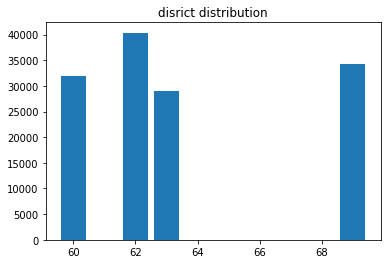

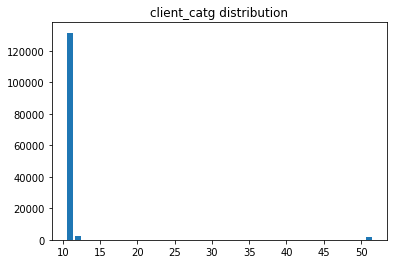

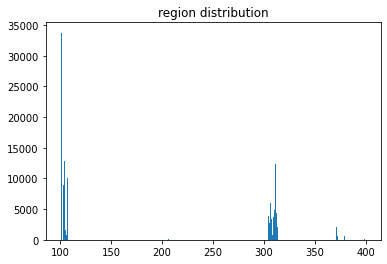

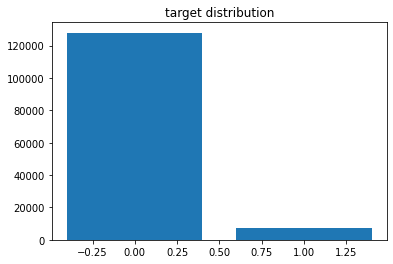

In [ ]:
# Ploting data from the client training data
client_columns = ['disrict', 'client_catg' ,  'region' ,  'target']
for col in client_columns:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

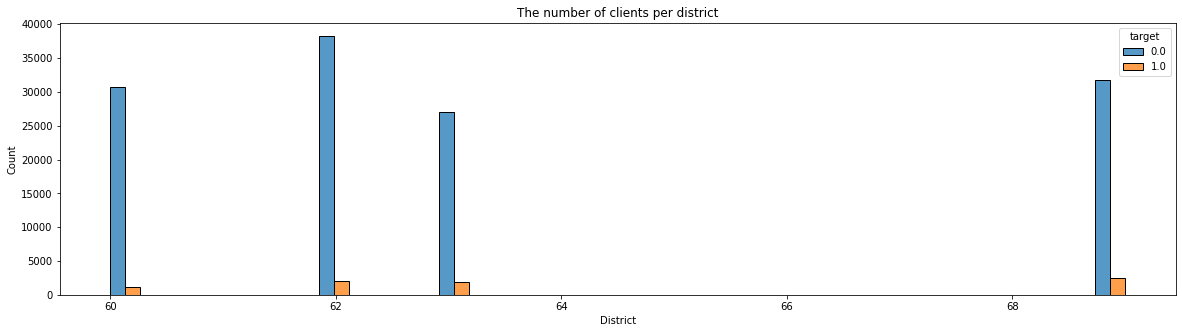

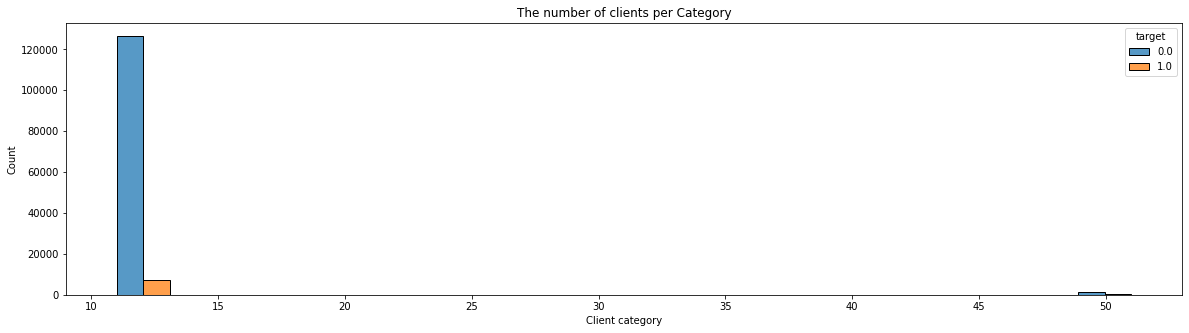

In [ ]:
figure(figsize=(20,5))
sns.histplot(client_train, x='disrict', hue='target', multiple='dodge')
plt.xlabel('District')
plt.ylabel('Count')
plt.title('The number of clients per district')
plt.show()

figure(figsize=(20,5))
sns.histplot(client_train, x='client_catg', hue='target', multiple='dodge')
plt.xlabel('Client category')
plt.ylabel('Count')
plt.title('The number of clients per Category')
plt.show()

It is intersting to see that the  districts have approximately the same number of clients. 

In [ ]:
print("The pourcentage of fraudulent client in the dataset is :{:.2f}%".format(100*client_train['target'].sum() / client_train.shape[0]))

The pourcentage of fraudulent client in the dataset is :5.58%


##Data cleaning and merging

In [ ]:
def clean_invoice_data(invoice_df):
    ###### Cleaning the Invoice train/test data

    # Encode tha counter_type column, 1 for ELEC and 0 for GAZ
    invoice_df['counter_type'] = np.where(invoice_df["counter_type"].str.contains("ELEC"), 1, 0)
    
    # Convert invoice_date column to date and create other column for year, month
    invoice_df['invoice_date'] = pd.to_datetime(invoice_df['invoice_date'], dayfirst=True)
    invoice_df['invoice_month'] = invoice_df['invoice_date'].dt.month
    invoice_df['invoice_year'] = invoice_df['invoice_date'].dt.year
    invoice_df['is_weekday'] = ((pd.DatetimeIndex(invoice_df['invoice_date']).dayofweek) // 5 == 1).astype(float)

    # cleaned the counter_statue column and convert it into numeric
    invoice_df['counter_statue'] = pd.to_numeric(invoice_df['counter_statue']
                                                 .map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5}))

    # Extract only useful column for training
    df = invoice_df[['client_id', 'counter_type','invoice_month', 'invoice_year', 'is_weekday', 'tarif_type', 'counter_statue',
                     'counter_code', 'reading_remarque','counter_coefficient']].groupby(['client_id']).mean()   

    invoice_df['delta_index'] = (invoice_df['old_index'] - invoice_df['new_index']) / invoice_df['months_number']
    
    invoice_df['consumption_per_month'] = invoice_df[[ 
                     'consommation_level_1', 
                     'consommation_level_2',
                     'consommation_level_3', 
                     'consommation_level_4']].sum(axis=1)
    
    invoice_df['consumption_per_month'] = invoice_df['consumption_per_month'] / invoice_df['months_number']
    df['consumption_per_month'] = invoice_df.groupby('client_id').mean()['consumption_per_month']
    df['delta_index'] = invoice_df.groupby('client_id').mean()['delta_index']

    return df

def clean_client_data(client_df):
    ################################################################################################################################

    ###### Cleaning the Client train/test data
    # we divide the 'region' column into three-group column  
    client_df['regions'] = client_df['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200) 

    # we created the 'working_time' column as an  amount of time since account creation in months, start date is 31/12/2018 is 2019
    client_df['creation_date'] = pd.to_datetime(client_df['creation_date'])
    client_df['working_time'] = (2019 - client_df['creation_date'].dt.year)*12 - client_df['creation_date'].dt.month
    # the following columns were turned into categories
    client_df['client_catg'] = client_df['client_catg'].astype('category')
    client_df['disrict'] = client_df['disrict'].astype('category')
    client_df['regions'] = client_df['regions'].astype('category')

    # we droped unneccesary columns
    client_df = client_df.drop(columns=['creation_date','region'])

    return client_df


def merge_dataframe(client_df, invoice_df):
    return invoice_df.merge(client_df,  on='client_id')

In [ ]:
# using the implemented function for clean the invoice training data
invoice_train_df = clean_invoice_data(invoice_train)
# using the implemented function for clean the client training data
client_train_df = clean_client_data(client_train)
# Merge the two data frame
train_data = merge_dataframe(client_train_df, invoice_train_df)

# using the implemented function for clean the invoice testing data
invoice_test_df = clean_invoice_data(invoice_test)
# using the implemented function for clean the client testing data
client_test_df = clean_client_data(client_test)
# Merge the two data frame
test_data = merge_dataframe(client_test_df, invoice_test_df)

train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135493 entries, 0 to 135492
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   client_id              135493 non-null  object  
 1   counter_type           135493 non-null  float64 
 2   invoice_month          135493 non-null  float64 
 3   invoice_year           135493 non-null  float64 
 4   is_weekday             135493 non-null  float64 
 5   tarif_type             135493 non-null  float64 
 6   counter_statue         135493 non-null  float64 
 7   counter_code           135493 non-null  float64 
 8   reading_remarque       135493 non-null  float64 
 9   counter_coefficient    135493 non-null  float64 
 10  consumption_per_month  135493 non-null  float64 
 11  delta_index            135493 non-null  float64 
 12  disrict                135493 non-null  category
 13  client_catg            135493 non-null  category
 14  target              

,client_id,counter_type,invoice_month,invoice_year,is_weekday,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consumption_per_month,delta_index,disrict,client_catg,target,regions,working_time
0,train_Client_0,1.0,6.7,2011.1,0.0,11.0,0.0,203.7,7.0,1.0,82.5,-82.5,60,11,0.0,200,288
1,train_Client_1,1.0,5.1,2011.8,0.1,11.0,0.0,203.0,7.2,1.0,129.4,-129.4,69,11,0.0,200,199
2,train_Client_10,1.0,6.6,2010.9,0.1,11.0,0.0,203.2,7.1,1.0,127.0,-127.0,62,11,0.0,300,393
3,train_Client_100,1.0,5.5,2008.6,0.1,11.0,0.0,413.0,6.2,1.0,0.3,-0.3,69,11,0.0,200,265
4,train_Client_1000,1.0,7.6,2016.9,0.3,11.0,0.0,207.0,8.9,1.0,237.9,-237.9,62,11,0.0,300,50


here we plot the coorelation of our data 

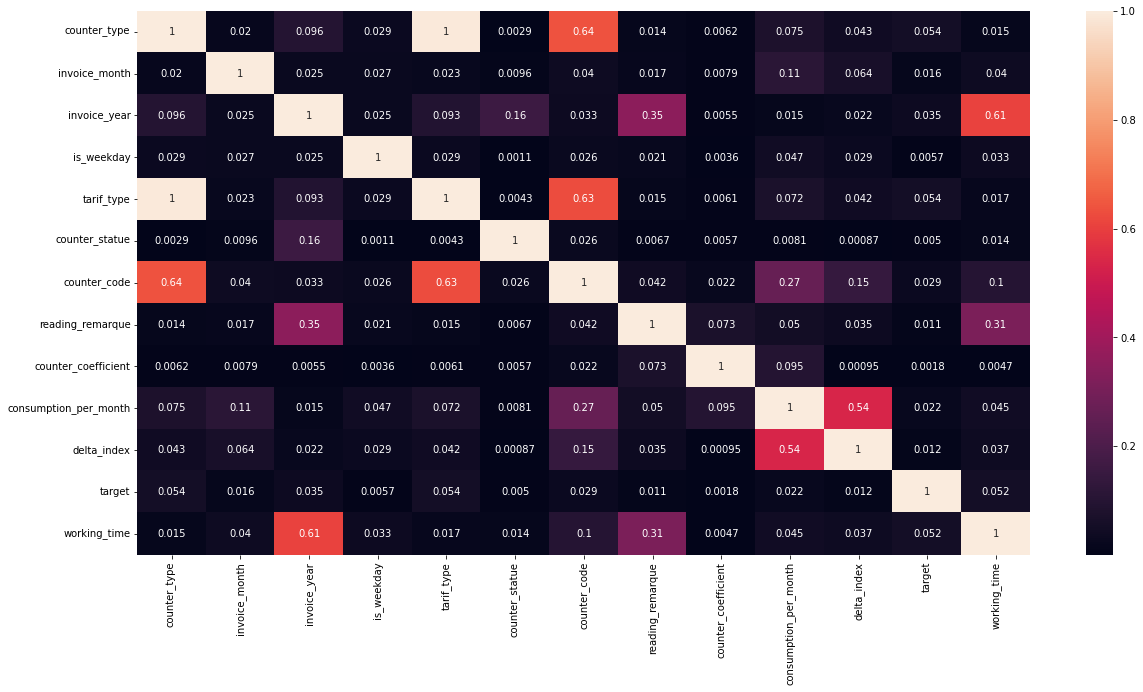

In [ ]:
figure(figsize=(20,10))
sns.heatmap(train_data.corr().abs(), annot=True)

Now to seperate the training and target columns for both training and testing datasets.

In [ ]:
y = train_data['target']
X = train_data.drop(['client_id','target'],axis=1)

X_test = test_data.drop(['client_id'], axis=1)

we seperate the category columns 

In [ ]:
category_cols = ['disrict', 'client_catg', 'regions']

Now to are ready to fit our model with a help of a hyperparameter optimzer called Optuna, i used it in a diffirent environment with a GPU accelerator

and here with used '**StratifiedKFold**' to train our model in batchs and ROC AUC as a measurement of accuracy

In [20]:
%%time
# we got this parameters from an outside job using optuna hyperparamaters optimizer with GPU acceleration
model = LGBMClassifier(random_state=seed, n_estimators=990,num_leaves=362, max_depth=124,
                       learning_rate=0.008, min_split_gain=0.028, 
                       feature_fraction=0.65, bagging_freq=1)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
result=[]
local_probs=pd.DataFrame()
probs = pd.DataFrame()

for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
    X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=30, verbose=False)
    
    preds = model.predict_proba(X_valid)
    tmp_predict = model.predict_proba(X_test)
    local_probs['fold_%i'%i] = tmp_predict[:,1]
    result.append(roc_auc_score(y_valid, preds[:,1]))

print('ROC AUC:', round(np.mean(result), 6))    
local_probs['result'] = local_probs.mean(axis=1)
probs['target'] = local_probs['result']


ROC AUC: 0.778186
CPU times: user 5min 36s, sys: 4.86 s, total: 5min 41s
Wall time: 3min 31s


this code is for extracing the predictions of the test_client_data into a csv file

In [ ]:
submission = pd.DataFrame({
        "client_id": sample_submission["client_id"],
        "target": probs['target']
    })
submission.to_csv('Samplesubmission.csv', index=False)